# CitiBike Data Analysis
CitiBike hosts the data of all their trips: https://www.citibikenyc.com/system-data.  This includes, for every trip, the pick up and drop off location, the bike id, and start/end time.  Although the data is easily accessible, there are some small changes in the storage convention.  Below is a statistical overview of trips taken between January 2015 to December 2016 (2 years, inclusive).

In [1]:
## load libraries
import urllib
import time
import random
import pandas as pd
import numpy as np
from datetime import datetime
import dateutil
from geopy.distance import great_circle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import folium

## Preprocessing
Downloading the data, splitting it into a smaller subset (for testing and debugging the analysis), and a small bit of cleanup (mostly in keeping column names consistent).

In [2]:
## download data, if it's not already downloaded
files = []
for i in range (1,13):
    # 2015 files
    link = 'https://s3.amazonaws.com/tripdata/2015{:02d}-citibike-tripdata.zip'.format(i)
    fileName = './data/2015{:02d}-citibike-tripdata.zip'.format(i)
    if not os.path.isfile(fileName):
        urllib.request.urlretrieve(link, fileName)
    # 2016 files
    link = 'https://s3.amazonaws.com/tripdata/2016{:02d}-citibike-tripdata.zip'.format(i)
    fileName = './data/2016{:02d}-citibike-tripdata.zip'.format(i)
    if not os.path.isfile(fileName):
        urllib.request.urlretrieve(link, fileName)

In [3]:
## load data
loadAllData = True # either load everything, only a sample
startTime = time.time()

if loadAllData:
    
    # list of files names
    files2015 = []
    files2016 = []
    for i in range(1,13):
        files2015.append('./data/2015{:02d}'.format(i) + '-citibike-tripdata.zip') 
        files2016.append('./data/2016{:02d}'.format(i) + '-citibike-tripdata.zip')
    files = files2015 + files2016

    # load data for january (to initate and for testing)
    df = pd.read_csv(files2015[0], compression='infer')

    # load the data for the rest of the year
        # column names in 2016 are different from 2015: set to 2015 convention
    new_columns = {'Bike ID': 'bikeid', 'Bike ID': 'bikeid', 'Birth Year': 'birth year', 
       'End Station ID': 'end station id', 'End Station Latitude': 'end station latitude',
       'End Station Longitude': 'end station longitude', 'End Station Name': 'end station name',
       'Gender': 'gender', 'Start Station ID': 'start station id', 
       'Start Station Latitude': 'start station latitude', 
       'Start Station Longitude': 'start station longitude', 
       'Start Station Name': 'start station name', 'Start Time': 'starttime',
       'Stop Time': 'stoptime', 'Trip Duration': 'tripduration', 'User Type': 'usertype'}

        # load the data from Feb 2015 to Dec 2016 (23 months)
    for i in range(1,len(files)):
        df2 = pd.read_csv(files[i], compression='infer')
        if i > 12: # remove 'seconds' in 2016 time stamps and rename columns
            df2.rename(columns=new_columns, inplace=True)
            df2.starttime = df2.starttime.apply(lambda x: str(x)[:-3])
        df = df.append(df2, ignore_index=True)
        
    # save a sample (1%) of the total data for approximate analysis
    if not os.path.isfile('./data/sampled_data.gzip'):
        df_sample = df.sample(frac=0.01)
        df_sample.reset_index(drop=True, inplace=True)
        df_sample.to_csv('./data/sampled_data.gzip', index=False, compression='gzip')
    
else:
    df = []
    df = pd.read_csv('./data/sampled_data.gzip', compression='gzip')

# df2015 = pd.read_csv('./data/201501-citibike-tripdata.zip', compression='infer')
# df2016 = pd.read_csv('./data/201601-citibike-tripdata.zip', compression='infer')
df.sample(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
21749313,131,2016-10-31 15:10,2016-10-31 15:13:07,3398,Smith St & 9 St,40.674696,-73.997858,3384,Smith St & 3 St,40.678724,-73.995991,16024,Subscriber,1980.0,2
2453981,1279,6/2/2015 0:07,6/2/2015 0:28,519,Pershing Square North,40.751873,-73.977706,236,St Marks Pl & 2 Ave,40.728419,-73.987140,15868,Subscriber,1982.0,1
18897822,476,9/8/2016 08:24,9/8/2016 08:32:55,150,E 2 St & Avenue C,40.720874,-73.980858,445,E 10 St & Avenue A,40.727408,-73.981420,16795,Subscriber,1946.0,1
16370797,685,7/17/2016 22:49,7/17/2016 23:01:16,282,Kent Ave & S 11 St,40.707645,-73.968415,430,York St & Jay St,40.701485,-73.986569,25980,Subscriber,1979.0,1
3613649,663,7/8/2015 12:39:16,7/8/2015 12:50:20,325,E 19 St & 3 Ave,40.736245,-73.984738,518,E 39 St & 2 Ave,40.747804,-73.973442,16793,Subscriber,1987.0,1


In [4]:
# df.info()

## Statistics!
There are some easy statistics to compute (means), and more difficult ones (estimated distance of travel).  The punchline here is that `pandas` is an extraordinarily versatile tool.  The following code produces the following useful information:
* The median duration of a trip is about 10 minutes
* About 2% of bikes are returned to the same starting station
* Each bike visits about 40 stations per year (there are about 620 stations)
* The average duration of a trip drops about 50% in the winter and increases by about 50% in the summer
* Nearly 4% of riders exceed the time limit (30 minutes for daily users, 45 minutes for subscribers)
* A lower bound to the average trip distance is 1.8 km
* A bike is moved by CitiBike employees (for re-balancing and such) about 120 times a year


In [5]:
# median trip duration
median = np.median(df.tripduration)
print('The median trip duration is {:.10g}'.format(median))

# fraction of trips that start and end at the same station
cycles = df[ df['start station id'] == df['end station id'] ]
fracCycles = len(cycles)/len(df)
print('The fraction of rides that start and end at the same station is {:.10g}'.format(fracCycles))

# number of unique stations
numStations = len(df['start station name'].unique()) # 471 stations by december

# number of unique stations a bike has visited
bike_gb = df.groupby('bikeid')
uniqueStations = []
for name,group in bike_gb:
    startStation = group['start station id']
    totalStation = startStation.append(group['end station id'])
    uniqueStations.append(totalStation.nunique())

meanStationVisits = np.mean(uniqueStations) # ~60
stdStationVisits = np.std(uniqueStations) #  ~25
print('The standard deviation of number of stations visited by a bike is {:g}'.format(stdStationVisits))

# average duration of trips for each month in the year
df['month'] = df.starttime.apply( dateutil.parser.parse )
df['month'] = df['month'].map( lambda x: x.month)
month_gb = df.groupby('month')
avgDur_month_df = month_gb['tripduration'].agg(np.mean)
diff_avgmonth = max(avgDur_month_df) - min(avgDur_month_df)
print('The difference between long and shortest average durations per month is {:.10g}'.format(diff_avgmonth))

# fraction of riders exceeding their corresponding time limit
rider_gb = df.groupby('usertype')
for name,group in rider_gb:
    if name == 'Customer':
        numCust = len(group)
        numOverCust = len(group[ group['tripduration'] > 60*30])
    elif name == 'Subscriber':
        numSub = len(group)
        numOverSub = len(group[ group['tripduration'] > 60*45])
    else:
        print('{:} user type was not included'.format(name))
fracOver = (numOverCust + numOverSub) / len(df)
print('The fraction of rides exceeding their corresponding time limit is {:.10g}'.format(fracOver))

# compute great circle distance 
def greatCircleDistance(row):
    startCoords = ( row['start station latitude'], row['start station longitude'])
    endCoords = ( row['end station latitude'], row['end station longitude'])
    return great_circle( startCoords,endCoords ).miles*1.6093
    
df['great_circle_distance'] = df.apply( greatCircleDistance,axis=1 )
meanGCDistance = np.mean(df['great_circle_distance'])
print('The average distance in km of a trip is {:.10g}'.format(meanGCDistance))

# hourly usage fraction
df['hour'] = df.starttime.apply( dateutil.parser.parse)
df['hour'] = df['hour'].map( lambda x: x.hour )
StationHr_gb = df.groupby(['start station id','hour'])
stationUsage = {}
maxStarts = 0
for stationhr,group in StationHr_gb:
    startStation,startHr = stationhr
    numStarts = len(group)
    stationUsage[startStation] = (startHr,numStarts)
    if numStarts > maxStarts:
        maxStarts = numStarts

totalHourUsage = len(df)/(24*numStations)
maxHourRatio = maxStarts / totalHourUsage
print('The largest ratio of station hourly usage to the sysem is {:.10g}'.format(maxHourRatio))

# detect number of moved bikes
moves = []
trips = []
for name,group in bike_gb:
    ending = group.as_matrix(columns=['end station id'])[0:-1]
    starting = group.as_matrix(columns=['start station id'])[1:]
    move = 0
    numTrips = len(ending)
    trips.append(numTrips+1)
    for i in range(0,numTrips): # loop over each trip the bike had
        if starting[i] != ending[i]:
            move = move + 1
    moves.append( move )
avgMovesPerBike = np.mean(moves)
avgTripsPerBike = np.mean(trips)
print('The average number of times a bike is moved is {:.10g}'.format(avgMovesPerBike))

elapsedTime = time.time() - startTime
print('Elapsed time to complete analysis is {:g}'.format(elapsedTime))


The median trip duration is 630
The fraction of rides that start and end at the same station is 0.02048207624
The standard deviation of number of stations visited by a bike is 79.3342
The difference between long and shortest average durations per month is 251.4503931
The fraction of rides exceeding their corresponding time limit is 0.03506942424
The average distance in km of a trip is 1.823782753
The largest ratio of station hourly usage to the sysem is 27.24711894
The average number of times a bike is moved is 246.2977252
Elapsed time to complete analysis is 8046.45


In [6]:
''' 
Out:

The median trip duration is 629.0000000
The fraction of rides that start and end at the same station is 0.022358391337304433
The standard deviation of number of stations visited by a bike is 54.541896535851848
The difference between long and shortest average durations per month is 430.57029597000519
The fraction of rides exceeding their corresponding time limit is 0.038106780168060496
The average distance in km of a trip is 1.7207471672452173
The largest ratio of station hourly usage to the sysem is 21.3787682372525
The average number of times a bike is moved is 155.40533207502654
(run time is 1 hour for full data set)

'''

' \nOut:\n\nThe median trip duration is 629.0000000\nThe fraction of rides that start and end at the same station is 0.022358391337304433\nThe standard deviation of number of stations visited by a bike is 54.541896535851848\nThe difference between long and shortest average durations per month is 430.57029597000519\nThe fraction of rides exceeding their corresponding time limit is 0.038106780168060496\nThe average distance in km of a trip is 1.7207471672452173\nThe largest ratio of station hourly usage to the sysem is 21.3787682372525\nThe average number of times a bike is moved is 155.40533207502654\n(run time is 1 hour for full data set)\n\n'

## Seasonal trends
Extracting the month and year in which a trip began from the time stamp data, we can plot the number of trips taken as a function of time in monthly intervals for the 24 months of collected data.  We can then easily see the seasonal trends in which most rides are taken in the early fall (I expected it would have peaked in the summer, but perhaps it's too hot).  A predictive model of the form 
$$y = a_1 t \left(1 + a_2\cos\left( 2\pi\frac{t}{12 \text{ months}} \right) \right),$$
where $a_i$ are fitting parameters that are found by least-squares regression
$$ \min\limits_{a_1, a_2} \sum_i \left( y(t_i) - y_i \right)^2,$$
can be used to estimate future usage of the Citibike system.  A station-specific model can also be formed, if the need arises.

In [7]:
## plot number of rides for each month
df_dtindex = pd.DatetimeIndex(df['starttime'])
month = np.core.defchararray.add(df_dtindex.month.astype(str), '-')
df['month_year'] = np.core.defchararray.add(month, df_dtindex.year.astype(str))
df.month_year = df.month_year.apply(lambda x: datetime.strptime(x, '%m-%Y'))
df.month_year = pd.to_datetime(df.month_year)

In [8]:
print(type(df.month_year[0]))

<class 'pandas.tslib.Timestamp'>


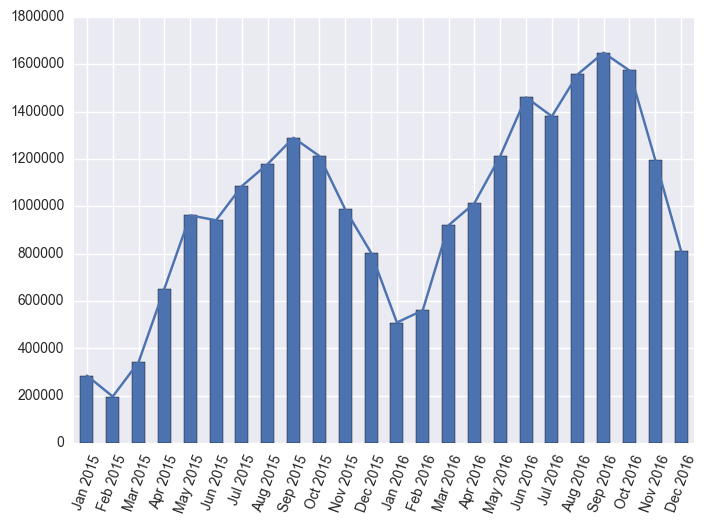

In [9]:
monthly_rides = df.month_year.value_counts().sort_index(ascending=True) # type=series
monthly_rides.index = [datetime.strftime(x, '%b %Y') for x in monthly_rides.index]
monthly_rides.plot(kind='bar', rot=70)
plt.plot(range(0,24), monthly_rides)

plt.show()

## Popular stations
Rather surprisingly, the most popular station to pick up a bike is also the most popular station to drop off a bike: Pershing Square North (independently confirmed [here](http://www.amny.com/transit/citi-bike-year-one-by-the-numbers-1.8188271)).  

The most popular pick-up stations are shown in red, next in purple, and least popular in blue.  The stations in Manhattan, having been online the longest, have been used much more frequently in the past 2 years (2015-2016) then those in Brooklyn.  The most popular station, Pershing Square North near Times Square, is shown in green.

In [15]:
## Create folium map based on most popular stations to start from

# setup the map
lat_center = 40.73 # manhattan, ny
long_center = -73.97
map_center = (lat_center, long_center)
popular_map = folium.Map(location=map_center, tiles='Stamen Toner', zoom_start=12)

# add station id points 
avg_station_uses = df.groupby('start station id').agg('count')['tripduration'].mean()
max_uses = 0
for name, group in df.groupby('start station id'):
    if len(group) > max_uses: max_name = name; max_uses = len(group);
    if len(group) > 1:
        if len(group) > 60000:
            color='red'
        elif len(group) > avg_station_uses:
            color='purple'
        else:
            color='blue'
        folium.CircleMarker([group['start station latitude'].values[0], 
                         group['start station longitude'].values[0]],
            radius=len(group)/1000, color=color, fill_color=color).add_to(popular_map)

# investigate the most popular station id
max_station_df = df[ df['start station id']==max_name ]
folium.CircleMarker([max_station_df['start station latitude'].values[0],
                    max_station_df['start station longitude'].values[0]],
                     radius=len(max_station_df)/1000, color='green', fill_color='green').add_to(popular_map)

# show map
popular_map

In [11]:
# average number of bikes taken from a station over 2 years
avg_station_uses

35926.92447129909

### Destination from Pershing Square
Here, we track the trips taken from Pershing Square and see where these riders go.  Similar to the map above, we plot the destination stations below.  Most riders head west and south west from the pick up point, with the most popular destination being W 41 St & 8 Ave.  Very few riders go all the way out to Brooklyn, though a non-signficant number head over to Central Park.

In [26]:
## consider where people from the most popular station go
name_popular = max_station_df['start station name'].values[0] # 'Pershing Square North'

# setup the map
lat_center = 40.73 # manhattan, ny
long_center = -73.97
map_center = (lat_center, long_center)
popular_map = folium.Map(location=map_center, tiles='Stamen Toner', zoom_start=12)

# loop over all end station ids from max_station_df
avg_station_uses = max_station_df.groupby('end station id').agg('count')['tripduration'].mean()
max_uses = 0
for name, group in max_station_df.groupby('end station id'):
    if len(group) > max_uses: max_name = name; max_uses = len(group);
    if len(group) > 1:
        if len(group) > 1500:
            color='red'
        elif len(group) > avg_station_uses:
            color='purple'
        else:
            color='blue'
        folium.CircleMarker([group['end station latitude'].values[0], 
                         group['end station longitude'].values[0]],
            radius=len(group)/1000, color=color, fill_color=color).add_to(popular_map)

# investigate the most popular station id
max_station_end = max_station_df[ max_station_df['end station id']==max_name ] # 'W 41 St & 8 Ave'
folium.CircleMarker([max_station_end['end station latitude'].values[0],
                    max_station_end['end station longitude'].values[0]],
                     radius=len(max_station_end)*20/1000, color='green', fill_color='green').add_to(popular_map)

# show map
popular_map

In [17]:
avg_station_uses

430.58347386172005

In [13]:
# ## Create folium map based on most popular stations to end at

# # setup the map
# lat_center = 40.73 # manhattan, ny
# long_center = -73.97
# map_center = (lat_center, long_center)
# popular_map = folium.Map(location=map_center, tiles='Stamen Toner', zoom_start=12)

# # add station id points 
# avg_station_uses = df.groupby('end station id').agg('count')['tripduration'].mean()
# max_uses = 0
# for name, group in df.groupby('end station id'):
#     if len(group) > max_uses: max_name = name; max_uses = len(group);
#     if len(group) > 1:
#         if len(group) > 1000:
#             color='red'
#         elif len(group) > avg_station_uses:
#             color='purple'
#         else:
#             color='blue'
#         folium.CircleMarker([group['end station latitude'].values[0], 
#                          group['end station longitude'].values[0]],
#             radius=len(group)/10, color=color, fill_color=color).add_to(popular_map)

# # investigate the most popular station id
# max_station_df = df[ df['end station id']==max_name ] # 'Pershing Square North'
# folium.CircleMarker([max_station_df['end station latitude'].values[0],
#                     max_station_df['end station longitude'].values[0]],
#                      radius=len(max_station_df)/10, color='green', fill_color='green').add_to(popular_map)

# # show map
# popular_map

In [14]:
## consider where people from the most popular station go
name_popular = max_station_df['end station name'].values[0] # 'Pershing Square North'